In [546]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import kmapper as km
from kmapper.jupyter import display
import umap
import sklearn.manifold as manifold

## Unsupervised Learning

In [2]:
# Read in data for teams, Competitions, Players and Playerank 

teams = pd.read_json("~/Downloads/teams.json")
competitions = pd.read_json("~/Downloads/competitions.json")
players = pd.read_json("~/Downloads/players.json")
playerank = pd.read_json("~/Downloads/playerank.json")

# Read in match events for every competition
events_World_Cup = pd.read_json("~/Downloads/events/events_World_Cup.json")
events_England = pd.read_json("~/Downloads/events/events_England.json")
events_European_Championship = pd.read_json("~/Downloads/events/events_European_Championship.json")
events_France = pd.read_json("~/Downloads/events/events_France.json")
events_Germany = pd.read_json("~/Downloads/events/events_Germany.json")
events_Italy = pd.read_json("~/Downloads/events/events_Italy.json")
events_Spain = pd.read_json("~/Downloads/events/events_Spain.json")

# Read in event and tag id mappings
event_mapping = pd.read_csv("~/Downloads/eventid2name.csv")
tags_mapping = pd.read_csv("~/Downloads/tags2name.csv")

In [396]:
# Merge all events
all_events = [
    events_World_Cup,
    events_England,
    events_European_Championship,
    events_France,
    events_Germany,
    events_Italy,
    events_Spain
]

# Concatenate all DataFrames vertically (axis=0)
combined_events = pd.concat(all_events, axis=0, ignore_index=True)

3251294


In [397]:
# Look at combined dataset
combined_events.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],122671,"[{'y': 50, 'x': 50}, {'y': 53, 'x': 35}]",2057954,Pass,16521,1H,1.656214,85,258612104
1,8,High pass,[{'id': 1801}],139393,"[{'y': 53, 'x': 35}, {'y': 19, 'x': 75}]",2057954,Pass,16521,1H,4.487814,83,258612106
2,1,Air duel,"[{'id': 703}, {'id': 1801}]",103668,"[{'y': 81, 'x': 25}, {'y': 83, 'x': 37}]",2057954,Duel,14358,1H,5.937411,10,258612077
3,1,Air duel,"[{'id': 701}, {'id': 1802}]",122940,"[{'y': 19, 'x': 75}, {'y': 17, 'x': 63}]",2057954,Duel,16521,1H,6.406961,10,258612112
4,8,Simple pass,[{'id': 1801}],122847,"[{'y': 17, 'x': 63}, {'y': 15, 'x': 71}]",2057954,Pass,16521,1H,8.562167,85,258612110


In [343]:
# Convert playerank into minutes played for each player
playerminutes = playerank.drop(['goalScored','matchId'],axis = 1)
playerminutes = playerminutes.groupby('playerId').agg({
    'roleCluster': lambda x: set(x),  # Collect unique roles as a set
    'minutesPlayed': 'sum',            # Sum all minutes played
    'playerankScore': lambda x: np.mean(x)
}).reset_index()  # Optional: Convert 'playerId' back to a column

In [344]:
# Look at first few rows
playerminutes.head()

,playerId,roleCluster,minutesPlayed,playerankScore
0,12,{left CB},180,0.010700
1,36,"{left CB, right MF, right CB}",2160,0.008550
2,38,{left MF},347,0.001000
3,45,{right MF},288,0.001180
4,48,"{left MF, central MF-left CB, left CB, left CB...",4104,0.011824


In [398]:
# Inner join players and events
full_df = pd.merge(combined_events, players ,left_on = "playerId", right_on = "wyId", how = "inner")

# Drop unnecessary columns
full_df = full_df.drop(['eventId','matchId','matchPeriod','eventSec','firstName','lastName',
                                 'birthDate','birthArea','wyId','foot','currentNationalTeamId','id',
                                 'passportArea','weight','middleName'], axis = 1)

full_df.head()

,subEventName,tags,playerId,positions,eventName,teamId,subEventId,currentTeamId,height,role,shortName
0,Simple pass,[{'id': 1801}],122671,"[{'y': 50, 'x': 50}, {'y': 53, 'x': 35}]",Pass,16521,85,16470,179,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...",Mohammad Al Sahlawi
1,High pass,[{'id': 1801}],139393,"[{'y': 53, 'x': 35}, {'y': 19, 'x': 75}]",Pass,16521,83,16467,177,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",Abdullah Otayf
2,Air duel,"[{'id': 703}, {'id': 1801}]",103668,"[{'y': 81, 'x': 25}, {'y': 83, 'x': 37}]",Duel,14358,10,13888,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",I. Kutepov
3,Air duel,"[{'id': 701}, {'id': 1802}]",122940,"[{'y': 19, 'x': 75}, {'y': 17, 'x': 63}]",Duel,16521,10,16467,170,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...",Yasir Al Shahrani
4,Simple pass,[{'id': 1801}],122847,"[{'y': 17, 'x': 63}, {'y': 15, 'x': 71}]",Pass,16521,85,16467,179,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...",Salman Al Faraj


Now that we have a combined dataset containing all match events and any relevant information, we need to find normalized metrics that allows our model to determine clusters and natural groups between players. Thus, a list of per 90 minute stats that could be useful and are found in the dataset: Air Duels/90, Defensive Ground Duels/90, Accelerations/90, Touch/90, Cross/90, Saves/90, Goalkeeper Leaving Line per 90, Long Pass/90, Short Pass/90, Shots/90, Fouls/90, Others on the Ball/90, Clearances/90, Save Attempt per 90, Take Ons/90, Dribbles/90, Interceptions/90. Additional metrics such as distance traveled could also be useful, but are not available in the dataset.

In [399]:
def extract_count(df, subevents, tag_list = None):
    """
    Extracts and counts player occurrences for specific subevents and optional tags.
    
    Parameters:
    - df (DataFrame): Input dataframe containing event data
    - subevents (list): List of subevent names to filter on
    - tag_list (list, optional): List of tag IDs to filter on. Defaults to None.
    
    Returns:
    - Series: Counts of events per playerId, filtered by subevents and tags (if provided)
    """
    
    # Keep only relevant columns from the input dataframe
    df = df[["subEventName","tags","playerId"]]
    
    # Helper function to extract relevant tags from the tags column
    def extract_relevant_tags(tags):
        """Extracts tag IDs that are present in the provided tag_list"""
        return [tag['id'] for tag in tags if tag['id'] in tag_list]

    # Filter dataframe to only include rows with the specified subevents
    filtered_df = df[df["subEventName"].isin(subevents)].copy()
    
    if (tag_list is not None):
        # If tag_list is provided:
        # 1. Extract relevant tags from each row's tags
        filtered_df['tag_ids'] = filtered_df['tags'].apply(extract_relevant_tags)
        # 2. Explode the list of tags so each tag gets its own row
        exploded_df = filtered_df.explode('tag_ids')
        # 3. Count occurrences per player
        event_counts = exploded_df.groupby('playerId').size().rename('count')
    else:
        # If no tag_list provided, simply count subevent occurrences per player
        event_counts = filtered_df.groupby('playerId').size().rename('count')
        
    return event_counts

In [492]:
# Extract player counts for each statistic
airDuelsCount = extract_count(full_df, ["Air duel"])
groundDefendingDuelsCount = extract_count(full_df, ["Ground defending duel"])
takeOnDuelsCount = extract_count(full_df, ["Ground attacking duel"])
groundLooseBallDuelsCount = extract_count(full_df, ["Ground loose ball duel"])
accelerationsCount = extract_count(full_df, ["Acceleration"])
interceptionCount = extract_count(full_df, ["Touch"], [1402])
crossCount = extract_count(full_df, ["Cross"])
goalKickCount = extract_count(full_df, ["Goal kick"])
longPassCount = extract_count(full_df, ["High pass", "Launch"])
shortPassCount = extract_count(full_df, ["Simple pass","Head pass"])
smartPassCount = extract_count(full_df, ["Smart pass"])
shotCount = extract_count(full_df, ["Shot"])
clearancesCount = extract_count(full_df, ["Clearance"])

In [495]:
# Create a DataFrame from each series, preserving their indices (playerIds)
stats_data = {
    'airDuels': airDuelsCount,
    'groundDefendingDuels': groundDefendingDuelsCount,
    'takeOnDuels': takeOnDuelsCount,
    'groundLooseBallDuels': groundLooseBallDuelsCount,
    'accelerations': accelerationsCount,
    'interceptions': interceptionCount,
    'crosses': crossCount,
    'goalKicks': goalKickCount,
    'longPasses': longPassCount,
    'shortPasses': shortPassCount,
    'smartPasses': smartPassCount,
    'shots': shotCount,
    'clearances': clearancesCount
}

# Convert to DataFrame with playerId as index
stats_df = pd.DataFrame(stats_data)

# Merge with minutes data (keeping all players from stats_df)
combined_df = pd.merge(
    stats_df.reset_index().rename(columns={'index': 'playerId'}),
    playerminutes,
    on='playerId',
    how='left'
)

# Fill missing minutes with 0 and handle NaNs
combined_df['minutesPlayed'] = combined_df['minutesPlayed'].fillna(0)

# Calculate per90 metrics
metrics = stats_data.keys()
per90_data = {}

for metric in metrics:
    # Fill NaN in the metric with 0 first
    combined_df[metric] = combined_df[metric].fillna(0)
    
    # Calculate per90 (0 when minutes = 0)
    per90_data[f'{metric}_per90'] = np.where(
        combined_df['minutesPlayed'] > 0,
        combined_df[metric] / (combined_df['minutesPlayed'] / 90),
        0
    )

# Create final DataFrame with only player info and per90 stats
final_df = pd.DataFrame({
    'playerId': combined_df['playerId'],
    'roleCluster': combined_df['roleCluster'].fillna('Unknown'),
    'minutesPlayed': combined_df['minutesPlayed'],
    'playerankScore': combined_df['playerankScore']
})

# Add all per90 metrics
final_df = pd.concat([
    final_df,
    pd.DataFrame(per90_data)
], axis=1)

# Round per90 metrics to 2 decimals and fill any remaining NaNs
per90_cols = [col for col in final_df.columns if '_per90' in col]
final_df[per90_cols] = final_df[per90_cols].round(2).fillna(0)

# Filter columns to only keep player info and per90 stats
final_df = final_df[['playerId', 'minutesPlayed', 'playerankScore'] + per90_cols]

# Merge data with players to get name, role and height
final_df = pd.merge(final_df, players[['wyId','shortName', 'role', 'height']], left_on = 'playerId', right_on= 'wyId', how = 'left')
final_df = final_df.drop('wyId', axis = 1)

# Retrieve positional tag
final_df["role"] = final_df["role"].apply(lambda x: x.get("code2"))

original_length = len(final_df)

In [497]:
# Drop rows with 'GK' as position as no minutes available as well as any players with less than 300 minutes played
final_df = final_df[final_df["role"] != 'GK'] 
final_df = final_df[final_df["minutesPlayed"] >= 300] 
new_length = len(final_df)
print(f'Before dropping: {original_length} samples')
print(f'After dropping: {new_length} samples')
print(f'Rows dropped: {original_length - new_length} samples')

Before dropping: 3033 samples
After dropping: 1982 samples
Rows dropped: 1051 samples


## EDA

Now we want to see if there are any major imbalances/problems that need to be address. 

In [405]:
# Summary statistics for our data
final_df.describe()

,playerId,minutesPlayed,playerankScore,airDuels_per90,groundDefendingDuels_per90,takeOnDuels_per90,groundLooseBallDuels_per90,accelerations_per90,interceptions_per90,crosses_per90,goalKicks_per90,longPasses_per90,shortPasses_per90,smartPasses_per90,shots_per90,clearances_per90,height
count,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000,1982.000000
mean,102259.490414,1705.654390,0.006265,4.075888,6.514854,6.897841,3.538633,0.676978,4.347064,1.624591,0.001130,3.480469,34.020313,0.764793,1.123052,1.394879,181.751766
std,125565.456101,871.882832,0.007168,2.848926,2.245760,4.934570,1.362029,0.625850,1.174444,1.522224,0.014321,2.323880,13.320152,0.702152,0.893363,1.132675,6.227873
min,36.000000,301.000000,-0.020267,0.000000,1.030000,0.230000,0.750000,0.000000,1.240000,0.000000,0.000000,0.000000,8.910000,0.000000,0.000000,0.000000,162.000000
25%,14760.500000,957.500000,0.001650,2.270000,4.870000,2.842500,2.600000,0.200000,3.520000,0.390000,0.000000,1.512500,24.542500,0.260000,0.400000,0.490000,178.000000
50%,26009.000000,1659.500000,0.006238,3.410000,6.500000,5.830000,3.300000,0.500000,4.260000,1.160000,0.000000,3.260000,32.180000,0.590000,0.860000,1.020000,182.000000
75%,209184.500000,2385.500000,0.010885,4.940000,8.090000,10.075000,4.120000,0.997500,5.040000,2.490000,0.000000,5.007500,40.935000,1.060000,1.720000,2.120000,186.000000
max,523089.000000,4334.000000,0.043685,24.770000,16.260000,26.800000,11.490000,4.750000,10.000000,11.420000,0.450000,13.240000,97.520000,6.000000,5.420000,5.670000,203.000000


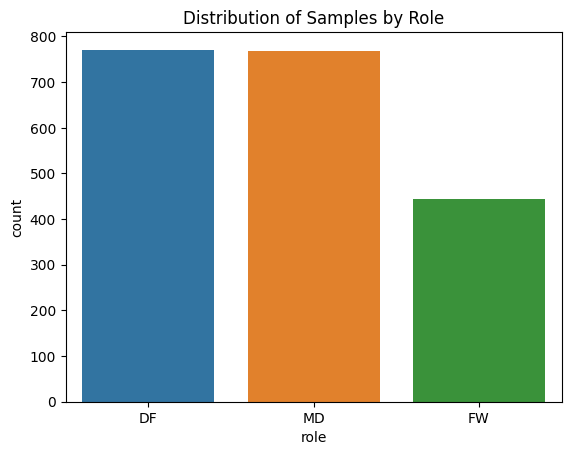

In [549]:
# Plot number of samples for each class
sns.countplot(final_df, x = 'role')
plt.title('Distribution of Samples by Role')
plt.show()

Our class imbalance is not too bad, and a good clustering algorithm should be able to deal with it. This may become a problem that needs to be addressed in the following classification task, but for now it is adequate. We see that the range for each feature is varying, some in the tens, some in the single digits, so we address this by standardizing each variable between 0-1.

In [550]:
# Drop classes from our final training dataset
train = final_df.drop(['playerId','minutesPlayed', 'shortName', 'role'], axis = 1)

In [551]:
# Standardize our features
scaler = StandardScaler()
train = scaler.fit_transform(train)

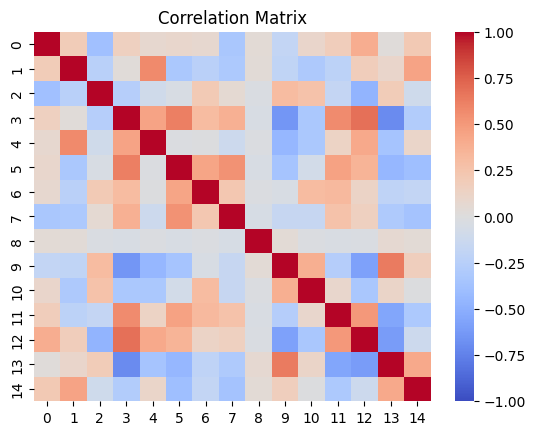

In [552]:
# Look for independent variables that are redundant with high covariance
corr_matrix = np.corrcoef(train, rowvar = False)
#upper_tri = corr_matrix.where(np.triu(np.ones_like(corr_matrix), k=1).astype(bool))
#to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]  # Threshold
#df_reduced = df.drop(to_drop, axis=1)
sns.heatmap(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [557]:
def drop_redundant_features(X, threshold=0.95):
    """
    Identifies and drops highly correlated (redundant) features from a dataset.
    
    Parameters:
    - X (numpy.ndarray): Input feature matrix (2D array)
    - threshold (float): Correlation threshold above which features are considered redundant (default: 0.95)
    
    Returns:
    - tuple: (filtered feature matrix with redundant columns removed, indices of kept columns)
    """
    
    # Calculate pairwise correlation matrix between all features
    # rowvar=False treats columns as variables (features) and rows as observations
    corr_matrix = np.corrcoef(X, rowvar=False)

    # Set diagonal (self-correlation) to 0 to avoid comparing features with themselves
    np.fill_diagonal(corr_matrix, 0)
    
    # Find all pairs of features where absolute correlation exceeds the threshold
    # Returns array of (i,j) index pairs where corr_matrix[i,j] > threshold
    redundant_pairs = np.column_stack(np.where(np.abs(corr_matrix) > threshold))
    print("Redundant feature pairs (indices):", redundant_pairs)
    
    # Determine which features to drop (keeping only one from each highly correlated pair)
    to_drop = set()
    for i, j in redundant_pairs:
        # If feature i hasn't been marked for dropping yet, mark feature j for dropping
        # This ensures we keep at least one feature from each correlated pair
        if i not in to_drop:
            to_drop.add(j)
    
    # Create list of column indices to keep (all columns not in to_drop set)
    keep_columns = [col for col in range(X.shape[1]) if col not in to_drop]
    
    # Return filtered feature matrix and list of kept column indices
    return X[:, keep_columns], keep_columns

train_filtered, kept_cols = drop_redundant_features(train, threshold=0.7)

Redundant feature pairs (indices): []


No features were found to be redundant.

## Model Training

In [558]:
# Create PCA object and train on filtered dataset
pca = PCA()
pca.fit(train_filtered)

PCA()

In [559]:
# Look at how much variance is explained by each principal component
pca.explained_variance_ratio_

array([0.30061182, 0.18894998, 0.10327089, 0.076811  , 0.06621084,
       0.05710069, 0.0404311 , 0.03232862, 0.03022738, 0.02609421,
       0.02196756, 0.01856372, 0.01570855, 0.01148175, 0.0102419 ])

Text(0, 0.5, 'Cumulative Explained Variance')

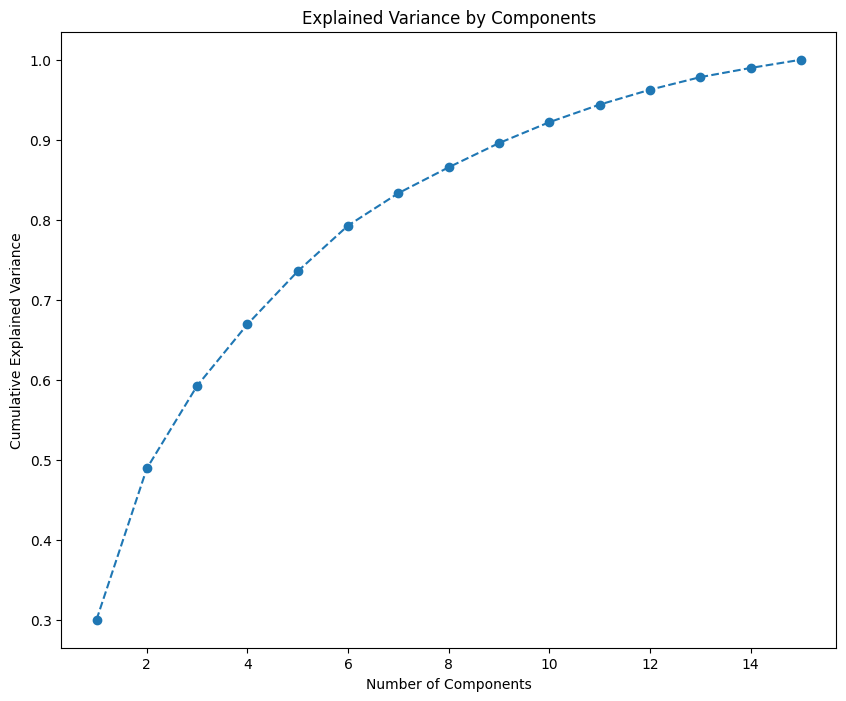

In [560]:
# Plot cumulative explained variance versus number of components
plt.figure(figsize = (10,8))
plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [562]:
# Train and fit PCA model with number of components that explains around 80% of variance
pca = PCA(n_components = 6).fit(train_filtered)

# Transform data
pca_train = pca.transform(train_filtered)

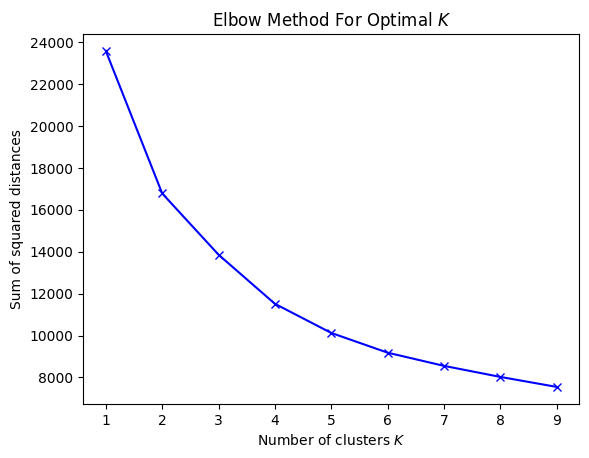

In [563]:
# Search for "optimal" number of clusters
SS_dist = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters, n_init = 10)
    kmeans.fit(pca_train)
    SS_dist.append(kmeans.inertia_)
plt.plot(K,SS_dist,'bx-')
plt.xlabel('Number of clusters $K$') 
plt.ylabel('Sum of squared distances') 
plt.title('Elbow Method For Optimal $K$')
plt.show()

In [185]:
# Rerun KMeanswith optimal number of clusters
kmeans_pca = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42, n_init = 10).fit(pca_train)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [438]:
# Fit DBSCAN
dbscan = DBSCAN(eps = 1, min_samples = 30).fit(pca_train)

In [486]:
# Create DataFrame with original labels, PCA components and clustering groups
df_segm_pca = pd.concat([final_df.reset_index(drop = True), pd.DataFrame(pca_train)], axis = 1)
df_segm_pca.columns.values[-6:] = ['Comp 1', 'Comp 2', 'Comp 3', 'Comp 4', 'Comp 5','Comp 6']
df_segm_pca["KMeans PCA Labels"] = kmeans_pca.labels_
df_segm_pca["DBSCAN PCA Labels"] = dbscan.labels_

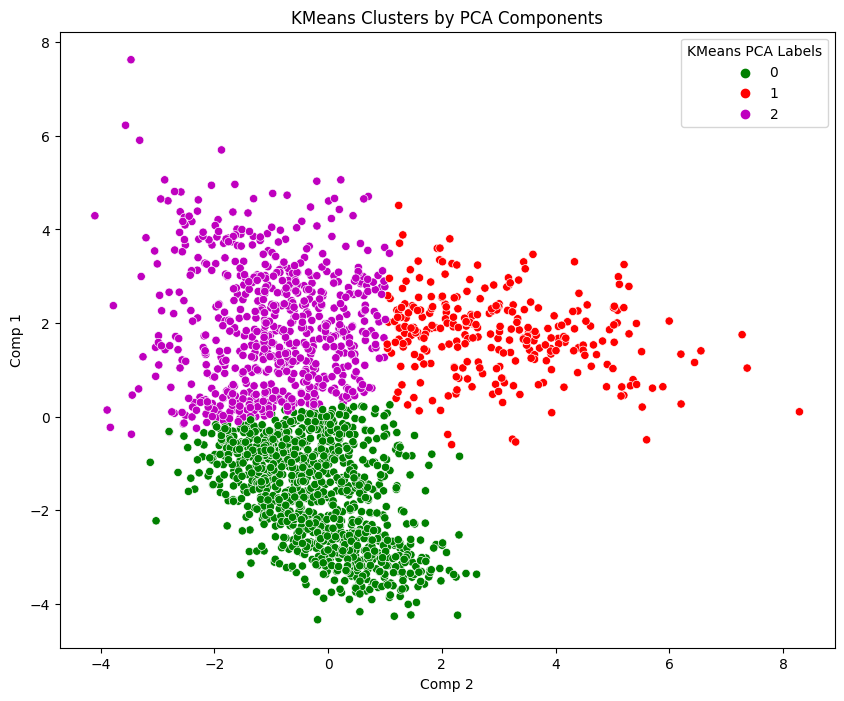

In [487]:
# Plot Kmeans clusters
x_axis = df_segm_pca['Comp 2']
y_axis = df_segm_pca['Comp 1']
plt.figure(figsize = (10,8))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_segm_pca["KMeans PCA Labels"], palette = ['g','r','m'])
plt.title('KMeans Clusters by PCA Components')
plt.show()

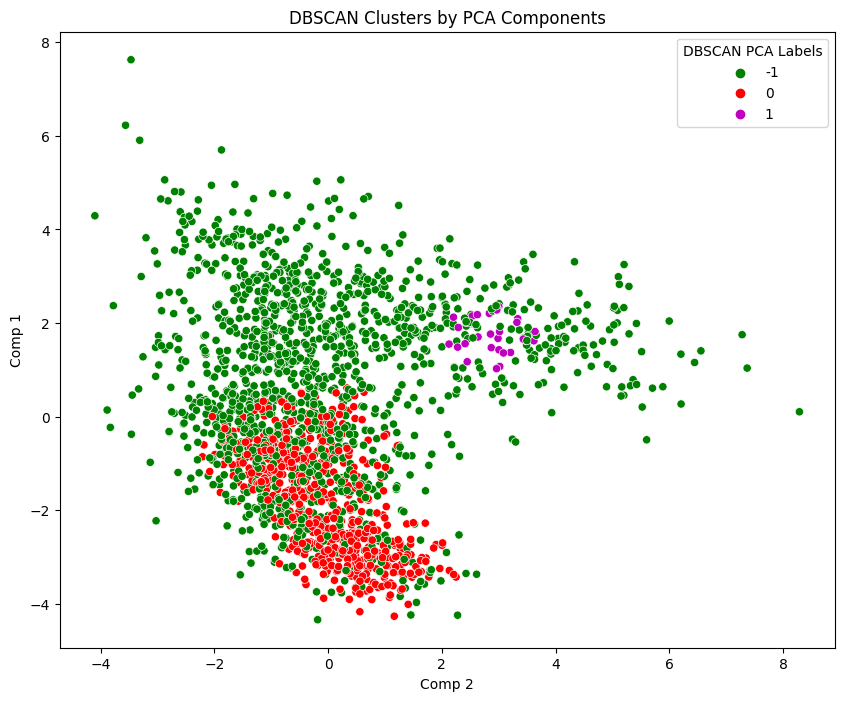

In [488]:
# Plot DBSCAN clusters
x_axis = df_segm_pca['Comp 2']
y_axis = df_segm_pca['Comp 1']
plt.figure(figsize = (10,8))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_segm_pca["DBSCAN PCA Labels"], palette = ['g','r','m'])
plt.title('DBSCAN Clusters by PCA Components')
plt.show()

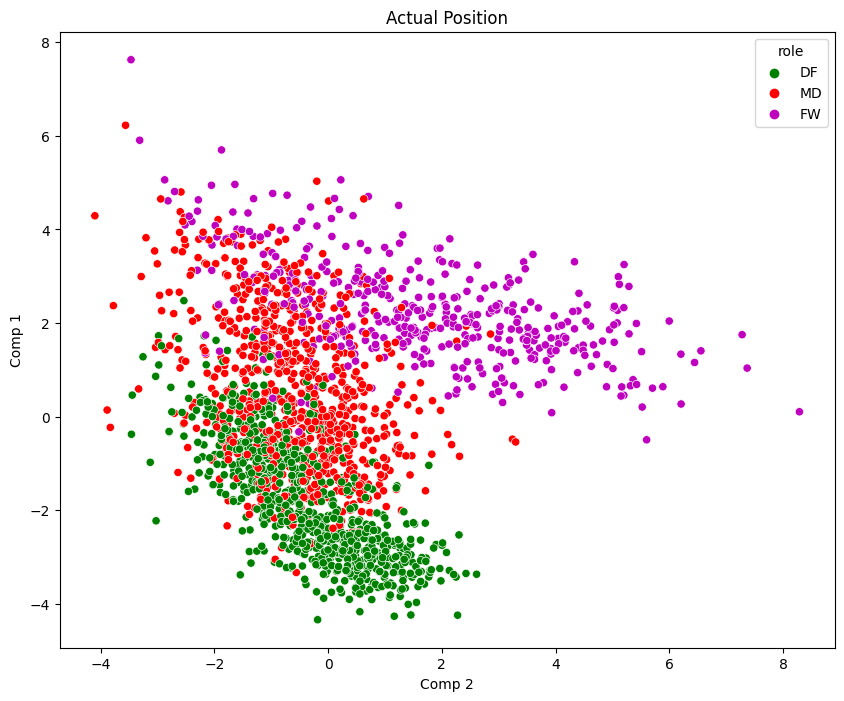

In [489]:
# Plot actual positions
x_axis = df_segm_pca['Comp 2']
y_axis = df_segm_pca['Comp 1']
plt.figure(figsize = (10,8))
sns.scatterplot(x = x_axis, y = y_axis, hue = df_segm_pca["role"], palette = ['g','r','m'])
plt.title('Actual Position')
plt.show()

In [490]:
# Replace cluster labels with position abbreviations
df_segm_pca['KMeans PCA Labels'] = df_segm_pca['KMeans PCA Labels'].map({
    0: 'DF',
    1: 'FW',
    2: 'MD'
})

df_segm_pca['DBSCAN PCA Labels'] = df_segm_pca['DBSCAN PCA Labels'].map({
    -1: 'MD',  # Typically -1 in DBSCAN represents noise points
    0: 'DF',
    1: 'FW'
})


KMEANS PCA CLUSTERING PERFORMANCE

CLASS-WISE METRICS:

DF Position:
• Precision: 0.666
• Recall:    0.891
• F1-Score:  0.762
• Support:   771.0

MD Position:
• Precision: 0.919
• Recall:    0.587
• F1-Score:  0.716
• Support:   443.0

FW Position:
• Precision: 0.602
• Recall:    0.523
• F1-Score:  0.560
• Support:   768.0

OVERALL METRICS:
• Accuracy:           0.681
• Weighted Precision: 0.698
• Weighted Recall:    0.681
• Weighted F1-Score:  0.674


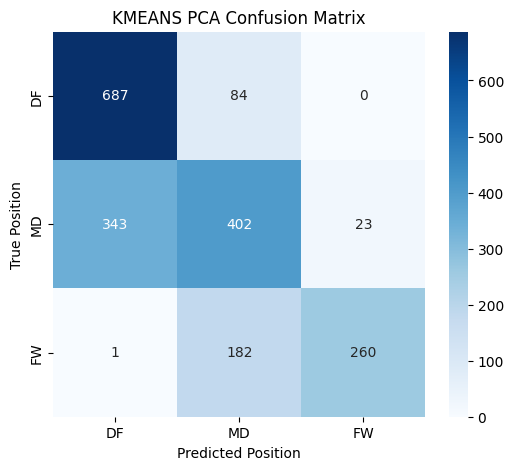


DBSCAN PCA CLUSTERING PERFORMANCE

CLASS-WISE METRICS:

DF Position:
• Precision: 0.755
• Recall:    0.591
• F1-Score:  0.663
• Support:   771.0

MD Position:
• Precision: 0.967
• Recall:    0.065
• F1-Score:  0.123
• Support:   443.0

FW Position:
• Precision: 0.459
• Recall:    0.806
• F1-Score:  0.585
• Support:   768.0

OVERALL METRICS:
• Accuracy:           0.557
• Weighted Precision: 0.688
• Weighted Recall:    0.557
• Weighted F1-Score:  0.512


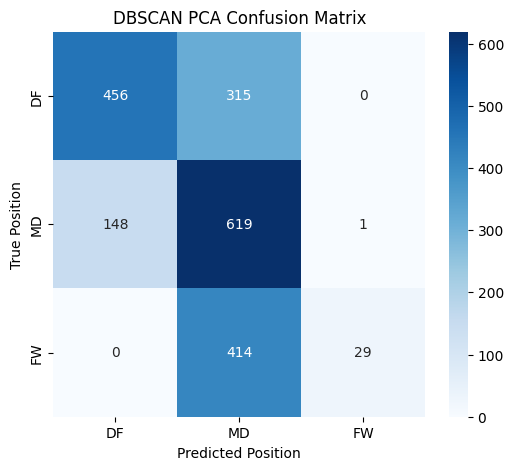

In [491]:
# Function to print metrics in simple format
def print_simple_metrics(true_labels, pred_labels, method_name):
    print(f"\n{'='*50}")
    print(f"{method_name} CLUSTERING PERFORMANCE")
    print('='*50)
    
    # Calculate all metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    report = classification_report(true_labels, pred_labels, 
                                 target_names=['DF', 'MD', 'FW'], 
                                 output_dict=True, zero_division = 0)
    
    # Print class-wise metrics
    print("\nCLASS-WISE METRICS:")
    for pos in ['DF', 'MD', 'FW']:
        print(f"\n{pos} Position:")
        print(f"• Precision: {report[pos]['precision']:.3f}")
        print(f"• Recall:    {report[pos]['recall']:.3f}")
        print(f"• F1-Score:  {report[pos]['f1-score']:.3f}")
        print(f"• Support:   {report[pos]['support']}")
    
    # Print overall metrics
    print("\nOVERALL METRICS:")
    print(f"• Accuracy:           {accuracy:.3f}")
    print(f"• Weighted Precision: {report['weighted avg']['precision']:.3f}")
    print(f"• Weighted Recall:    {report['weighted avg']['recall']:.3f}")
    print(f"• Weighted F1-Score:  {report['weighted avg']['f1-score']:.3f}")
    
    # Create and display confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=['DF', 'MD', 'FW'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['DF', 'MD', 'FW'],
                yticklabels=['DF', 'MD', 'FW'])
    plt.title(f'{method_name} Confusion Matrix')
    plt.ylabel('True Position')
    plt.xlabel('Predicted Position')
    plt.show()

# Evaluate and print results for both methods
print_simple_metrics(df_segm_pca['role'],
                   df_segm_pca['KMeans PCA Labels'],
                   "KMEANS PCA")

print_simple_metrics(df_segm_pca['role'],
                   df_segm_pca['DBSCAN PCA Labels'],
                   "DBSCAN PCA")

## Mapping Algorithm

In [262]:
mapper = km.KeplerMapper(verbose=1)

KeplerMapper(verbose=1)


In [389]:
projected_data = mapper.fit_transform(train, projection=[manifold.Isomap(n_components=100, n_jobs=-1), umap.UMAP(min_dist = 0.01, n_components=2,random_state=42, metric = 'cosine')])

..Composing projection pipeline of length 2:
	Projections: Isomap(n_components=100, n_jobs=-1)
		UMAP(metric='cosine', min_dist=0.01, random_state=42)
	Distance matrices: False
False
	Scalers: MinMaxScaler()
MinMaxScaler()
..Projecting on data shaped (1982, 15)

..Projecting data using: 
	Isomap(n_components=100, n_jobs=-1)


..Scaling with: MinMaxScaler()

..Projecting on data shaped (1982, 100)

..Projecting data using: 
	UMAP(metric='cosine', min_dist=0.01, random_state=42, verbose=1)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.01, n_jobs=1, random_state=42, verbose=1)
Thu Aug  7 12:37:50 2025 Construct fuzzy simplicial set


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Thu Aug  7 12:37:51 2025 Finding Nearest Neighbors
Thu Aug  7 12:37:52 2025 Finished Nearest Neighbor Search
Thu Aug  7 12:37:52 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Thu Aug  7 12:37:54 2025 Finished embedding

..Scaling with: MinMaxScaler()



In [390]:
# cluster data using DBSCAN
G = mapper.map(projected_data, train, clusterer=sklearn.cluster.DBSCAN(metric="cosine", eps = 5, min_samples = 15))

Mapping on data shaped (1982, 15) using lens shaped (1982, 2)

Creating 100 hypercubes.

Created 115 edges and 64 nodes in 0:00:00.071816.


In [391]:
# define an excessively long filename (helpful if saving multiple Mapper variants for single dataset)
fileID = 'projection=' + G['meta_data']['projection'].split('(')[0] + '_' + \
'n_cubes=' + str(G['meta_data']['n_cubes']) + '_' + \
'perc_overlap=' + str(G['meta_data']['perc_overlap']) + '_' + \
'clusterer=' + G['meta_data']['clusterer'].split('(')[0] + '_' + \
'scaler=' + G['meta_data']['scaler'].split('(')[0]

In [392]:
# visualize graph
mapper.visualize(G, 
                path_html= "mapper_example_" + fileID + ".html",
                title=fileID,
                custom_tooltips = np.array(final_df['shortName']),
                color_values = final_df['playerankScore'],
                color_function_name = 'Player Rank Scores',
                node_color_function = np.array(['average', 'std', 'sum', 'max', 'min']))

# display mapper in jupyter
km.jupyter.display("mapper_example_" + fileID + ".html")

Wrote visualization to: mapper_example_projection=UMAP_n_cubes=10_perc_overlap=0.1_clusterer=DBSCAN_scaler=MinMaxScaler.html


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/kmapper/visuals.py:344: RuntimeWarning: invalid value encountered in scalar divide
  height = np.floor(((bar / max_bucket_value) * 100) + 0.5)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/kmapper/visuals.py:345: RuntimeWarning: invalid value encountered in scalar divide
  perc = round((bar / sum_bucket_value) * 100.0, 1)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
